In [1]:
from brian2 import *
from scipy.signal import savgol_filter # used to smooth the output
from time import time
import seaborn as sns
from tqdm import tqdm
import networkx as nx

In [124]:
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

## E-prop 1

In [100]:
prefs.codegen.target = "numpy"        # Don't really know what's for, but I get a warning otherwise

def e_prop1(N_rec, mask, nb_sim): # mask applied to w_rec

    start_scope()

    ################################################################################
    # MODEL PARAMETERS
    ################################################################################

    # General parameters

    #nb_sim = 1000                         # number of successive simulations
    time_simulation = 1000*ms             # time of each simulation
    time_step = 1*ms                      # time step at which operations are executed
    defaultclock.dt = time_step           # set Brian's inner clock to the time step  
    n_batch = 1                           # number of simulations separating each weight update
    tau_m = 20*ms                         # membrane time constant of recurrent neurons
    alpha = exp(-time_step/tau_m)         # decay factor
    tau_out = 20*ms                       # membrane time constant of output neurons
    kappa = exp(-time_step/tau_out)       # leak factor
    gamma = 0.3                           # dampening factor (used for the calculus of h_i^t)
    lr = 0.003                            # learning rate used for Adam algorithm (article : 0.003)
    decay_epoch = 100                     # when to apply a decay to the learning rate
    lr_decay = 0.7                        # learning rate decay
    f_target = 10                         # target firing rate (article : 10Hz)

    # Neuron parameters

    N_in1 = 5                             # number of input neurons (group 1)
    N_in2 = 5                             # number of input neurons (group 2)
    #N_rec = 300                           # number of recurrent neurons
    N_out = 1                             # number of output neurons

    v_th = 0.61                           # firing threshold of recurrent neurons (article : 0.61)

    bias = [0 for _ in range(N_out)]      # readout neurons bias

    # Synapse parameters

    syn_delay = 1*ms                      # synaptic delay

    # feedback weights
    feedback_w = (1/sqrt(N_rec)) * np.random.randn(N_out, N_rec)

    w_in1 = (1/sqrt(N_in1)) * np.random.randn(N_in1 * N_rec) # input weights (group 1)
    w_in2 = (1/sqrt(N_in2)) * np.random.randn(N_in2 * N_rec) # input weights (group 2)
    w_rec = (1/sqrt(N_rec)) * np.random.randn(N_rec * N_rec) # recurrent weights
    w_out = (1/sqrt(N_rec)) * np.random.randn(N_rec * N_out) # ouput weights

    w_rec[mask] = 0


    ################################################################################
    # NEURONS DEFINITION
    ################################################################################

    eqs_rec = '''
    dv/dt = log(alpha)*v/(time_step) : 1 (unless refractory)
    '''

    eqs_out = '''
    dy/dt = log(kappa)*(y - l)/time_step : 1
    l : 1
    '''


    freq1 = 5 # frequence of one of the sinusoides to reproduce (Hz)

    k_max1 = int(1000/(2*freq1)) # length of a spike train
    n_max1 = 5 # number of spike trains

    times1 = np.array([10*k + (1000/freq1)*n for n in range(n_max1) for k in range(int(k_max1/10)) for _ in range(N_in1)])*ms
    indices1 = np.array([k for _ in range(round(times1.size/N_in1)) for k in range(N_in1)])

    G_in1 = SpikeGeneratorGroup(N_in1, indices1, times1) # Input neurons (group 1)


    freq2 = 3 # frequence of one of the sinusoides to reproduce (Hz)

    k_max2 = int(1000/(2*freq2))
    n_max2 = 3

    times2 = np.array([10*k + (1000/freq2)*n for n in range(n_max2) for k in range(int(k_max2/10)) for _ in range(N_in2)])*ms
    indices2 = np.array([k for _ in range(round(times2.size/N_in2)) for k in range(N_in2)])

    G_in2 = SpikeGeneratorGroup(N_in2, indices2, times2) # Input neurons (group 2)

    """ 
    # input neurons as in the article

    N_group = 2 # nb of groups
    ff = 100 # frequence of spike within a group

    times1 = np.array([(1000/ff)*n for n in range(round(ff/N_group)) for _ in range(N_in1)])*ms
    indices1 = np.array([k for _ in range(round(times1.size/N_in1)) for k in range(N_in1)])

    times2 = np.array([(1000/ff)*n for n in range(round(ff/N_group), 1000) for _ in range(N_in2)])*ms
    indices2 = np.array([k for _ in range(round(times2.size/N_in2)) for k in range(N_in2)])

    G_in1 = SpikeGeneratorGroup(N_in1, indices1, times1) # Input neurons (group 1)
    G_in2 = SpikeGeneratorGroup(N_in2, indices2, times2) # Input neurons (group 2)
    """

    # n_max = round((freq/1000) * ((time_simulation/time_step) - 10*(k_max - 1))) + 1 # number of spike trains (automatically calculated) (à revoir)

    # J'ai essayé ça pour regrouper les 2 groupes en 1 seul, mais ça marchait pas
    # times = np.concatenate((times1, times2))*ms
    # ind = np.concatenate((indices1, indices2))
    # G_in = SpikeGeneratorGroup(N_in, ind, times) 


    G_rec = NeuronGroup(N_rec, eqs_rec, threshold = 'v > v_th', reset = 'v -= v_th', refractory = 5*ms, method = 'exact') # Recurrent neurons
    G_out = NeuronGroup(N_out, eqs_out, method = 'exact') # Output neurons

    lim = [b/(1 - kappa) for b in bias]
    G_out.l = lim


    ################################################################################
    # SYNAPSES
    ################################################################################

    S_in1 = Synapses(G_in1, G_rec, 'w : 1', on_pre='v_post += w') # Input synapses (group 1)
    S_in1.connect()
    S_in1.w = w_in1
    S_in1.delay = syn_delay

    S_in2 = Synapses(G_in2, G_rec, 'w : 1', on_pre='v_post += w') # Input synapses (group 2)
    S_in2.connect()
    S_in2.w = w_in2
    S_in2.delay = syn_delay

    S_rec = Synapses(G_rec, G_rec, 'w : 1', on_pre='v_post += w') # Recurrent synapses
    S_rec.connect()
    S_rec.w = w_rec
    S_rec.delay = syn_delay

    S_out = Synapses(G_rec, G_out, 'w : 1', on_pre='y_post += w') # Output synapses
    S_out.connect()
    S_out.w = w_out
    S_out.delay = syn_delay


    ################################################################################
    # MONITORS
    ################################################################################

    spikemon_in1 = SpikeMonitor(G_in1)
    spikemon_in2 = SpikeMonitor(G_in2)
    spikemon_rec = SpikeMonitor(G_rec)
    statemon_rec = StateMonitor(G_rec, 'v', record=True)
    statemon_out = StateMonitor(G_out, 'y', record=True)


    ################################################################################
    # MAIN ALGORITHM
    ################################################################################

    ampl = 1.5 * np.random.rand(2, N_out) + 0.5 # 2 represents the nb of freq
    #target_seq = np.array([[ampl[0, k] * sin(2*pi*freq1*n/1000) + ampl[1, k] * sin(2*pi*freq2*n/1000) for n in arange(0, time_simulation/ms, time_step/ms)] for k in range(N_out)]) # teacher signal 

    target_seq = np.array([[(sin(2*pi*freq1*n/1000) + 1.5 * sin(2*pi*freq2*n/1000))/2 for n in arange(0, time_simulation/ms, time_step/ms)] for _ in range(N_out)]) # teacher signal 
    
    global sum_e_traces_in1
    global sum_e_traces_in2
    global sum_e_traces_rec
    global eligibility_traces_in1
    global eligibility_traces_in2
    global eligibility_traces_rec
    global weird_eligibility_traces

    global gradient_in1
    global gradient_in2
    global gradient_rec
    global gradient_out
    global gradient_f_rate

    global count_spikes_rec

    @network_operation(dt = time_step, when = 'end')
    def change_Sw():
        time = net.t
        step = round(round(time/time_step) % (time_simulation/ms))
        
        global sum_e_traces_in1
        global sum_e_traces_in2
        global sum_e_traces_rec
        global eligibility_traces_in1
        global eligibility_traces_in2
        global eligibility_traces_rec
        global weird_eligibility_traces

        global gradient_in1
        global gradient_in2
        global gradient_rec
        global gradient_out
        global gradient_f_rate

        global count_spikes_rec
        
        # Reset the vector of spikes
        spike_vec_in1 = np.zeros(N_in1)
        spike_vec_in2 = np.zeros(N_in2)
        spike_vec_rec = np.zeros(N_rec)

        spike_vec_in1[G_in1.spikes] = 1
        spike_vec_in2[G_in2.spikes] = 1
        spike_vec_rec[G_rec.spikes] = 1

        diff = (G_out.y - target_seq[:,step]).reshape(1,-1)
        V = np.dot(diff, feedback_w).reshape(N_rec)

        H = (gamma * np.maximum(0, 1 - abs((G_rec.v - v_th)/v_th))).reshape(1,-1)

        sum_e_traces_in1 = np.dot(kappa, sum_e_traces_in1) + np.dot(eligibility_traces_in1, H)
        gradient_in1 += np.multiply(sum_e_traces_in1, V)

        sum_e_traces_in2 = np.dot(kappa, sum_e_traces_in2) + np.dot(eligibility_traces_in2, H)
        gradient_in2 += np.multiply(sum_e_traces_in2, V)

        temp = np.dot(eligibility_traces_rec, H)

        sum_e_traces_rec = np.dot(kappa, sum_e_traces_rec) + temp
        gradient_rec += np.multiply(sum_e_traces_rec, V)

        weird_eligibility_traces = np.dot(kappa, weird_eligibility_traces) + spike_vec_rec.reshape(-1,1)
        gradient_out += np.dot(weird_eligibility_traces, diff)
        
        # Firing rate regularization
        count_spikes_rec += spike_vec_rec # increase current count of spikes
        if time/ms > 0:
            f_avg = time_step/time * count_spikes_rec # should be 1000*time_step = 1000ms
            gradient_f_rate += time_step/time * np.multiply(f_target - f_avg, temp)
        
        # Eligibility traces are computed at the end because at current time t, we need their value at time t-1
        eligibility_traces_in1 = np.dot(alpha, eligibility_traces_in1) + spike_vec_in1.reshape(-1,1)
        eligibility_traces_in2 = np.dot(alpha, eligibility_traces_in2) + spike_vec_in2.reshape(-1,1)
        eligibility_traces_rec = np.dot(alpha, eligibility_traces_rec) + spike_vec_rec.reshape(-1,1)

    # Now we can create the network       
    net = Network(G_in1, G_in2, G_rec, G_out, S_in1, S_in2, S_rec, S_out, spikemon_in1, spikemon_in2, spikemon_rec, statemon_rec, statemon_out, change_Sw)
    net.dt = time_step # set the network's inner clock to the time_step

    net.store('initialized network') # store the initialized network

    Output = [] # to store the output of each epoch

    W_list = [] # to store list of weights across epochs
    W_l_in1 = []
    W_l_in2 = []
    W_l_out = []

    # Initialize parameters for Adam (put them up)
    beta_1 = 0.9
    beta_2 = 0.999
    eps = 10**(-7)
    m_in1 = np.zeros(N_in1 * N_rec)
    m_in2 = np.zeros(N_in2 * N_rec)
    m_rec = np.zeros(N_rec * N_rec)
    m_out = np.zeros(N_rec * N_out)
    v_in1 = np.zeros(N_in1 * N_rec)
    v_in2 = np.zeros(N_in2 * N_rec)
    v_rec = np.zeros(N_rec * N_rec)
    v_out = np.zeros(N_rec * N_out)

    for k in tqdm(range(nb_sim)):
        net.restore('initialized network') # restore the initialized network at every simulation

        # reset everything but the weights (forgot to reset count_spike_rec!!)
        eligibility_traces_in1 = np.zeros((N_in1, 1))
        eligibility_traces_in2 = np.zeros((N_in2, 1))
        eligibility_traces_rec = np.zeros((N_rec, 1))
        weird_eligibility_traces = np.zeros((N_rec,1))
        sum_e_traces_in1 = np.zeros((N_in1, N_rec))
        sum_e_traces_in2 = np.zeros((N_in2, N_rec))
        sum_e_traces_rec = np.zeros((N_rec, N_rec)) # sum in the right of the synaptic update equation history

        gradient_in1 = np.zeros((N_in1, N_rec)) # gradient of input synapses weights (group 1)
        gradient_in2 = np.zeros((N_in2, N_rec)) # gradient of input synapses weights (group 2)
        gradient_rec = np.zeros((N_rec, N_rec)) # gradient of recurrent synapses weights
        gradient_out = np.zeros((N_rec, N_out)) # gradient of output synapses weights
        gradient_f_rate = np.zeros((N_rec, N_rec)) # gradient of firing rate

        count_spikes_rec = np.zeros(N_rec) # count nb of spikes per neuron at current time step

        # update the weights
        S_in1.w = w_in1
        S_in2.w = w_in2
        S_rec.w = w_rec
        S_out.w = w_out

        net.run(time_simulation)

        Output.append(statemon_out.y)
        W_list.append(S_rec.w[:].reshape((N_rec,N_rec)).copy())
        W_l_in1.append(S_in1.w[:].copy())
        W_l_in2.append(S_in2.w[:].copy())
        W_l_out.append(S_out.w[:].copy())

        #gradient_in1, gradient_in2, gradient_rec, gradient_out = compute_gradients(N_in1, N_in2, N_rec, N_out,1000, feedback_w, target_seq, spikemon_in1, spikemon_in2, spikemon_rec, statemon_rec, statemon_out)

        gradient_rec += gradient_f_rate

        # update the weights with Adam
        m_in1 = beta_1 * m_in1 + (1 - beta_1) * gradient_in1.reshape(N_in1 * N_rec)
        m_in2 = beta_1 * m_in2 + (1 - beta_1) * gradient_in2.reshape(N_in2 * N_rec)
        m_rec = beta_1 * m_rec + (1 - beta_1) * gradient_rec.reshape(N_rec * N_rec)
        m_out = beta_1 * m_out + (1 - beta_1) * gradient_out.reshape(N_rec * N_out)
        v_in1 = beta_2 * v_in1 + (1 - beta_2) * np.power(gradient_in1.reshape(N_in1 * N_rec), 2)
        v_in2 = beta_2 * v_in2 + (1 - beta_2) * np.power(gradient_in2.reshape(N_in2 * N_rec), 2)
        v_rec = beta_2 * v_rec + (1 - beta_2) * np.power(gradient_rec.reshape(N_rec * N_rec), 2)
        v_out = beta_2 * v_out + (1 - beta_2) * np.power(gradient_out.reshape(N_rec * N_out), 2)

        w_in1 = S_in1.w - lr * (m_in1/(1 - beta_1**(k+1))) / (np.sqrt(v_in1/(1 - beta_2**(k+1))) + eps)
        w_in2 = S_in2.w - lr * (m_in2/(1 - beta_1**(k+1))) / (np.sqrt(v_in2/(1 - beta_2**(k+1))) + eps)
        w_rec = S_rec.w - lr * (m_rec/(1 - beta_1**(k+1))) / (np.sqrt(v_rec/(1 - beta_2**(k+1))) + eps)
        w_out = S_out.w - lr * (m_out/(1 - beta_1**(k+1))) / (np.sqrt(v_out/(1 - beta_2**(k+1))) + eps)

        # Reset un-connected synapses to 0
        w_rec[mask] = 0

        if ((k+1) % decay_epoch == 0) : 
            lr *= lr_decay
    
    return Output, W_list, spikemon_in1, spikemon_in2, spikemon_rec, target_seq

## Create synaptic connectivity

In [101]:
def Watts_Strogatz(N, s, beta): # generate random graph with small-world properties
    mask = np.ones((N,N), dtype=bool)
    
    # start with regular ring lattice
    for i in range(N):
        for j in range(1,s+1):
            mask[(i+j) % N, i] = False
            mask[i, (i+j) % N] = False
            mask[(i-j) % N, i] = False
            mask[i, (i-j) % N] = False
    
    # re-wire edges with probability beta
    for i in range(N):
        l = [j for j in range(N) if abs(j-i) > s] # list of non-neighbors of i
        proba_r = np.random.rand(s)
        proba_l = np.random.rand(s)
        for j in range(1,s+1):
            if proba_r[j-1] < beta: # re-wire
                new = np.random.choice(l)
                mask[i, (i+j) % N] = True
                mask[i, new] = False
                l.append((i+j) % N)
                l.remove(new)
                
            if proba_l[j-1] < beta:
                new = np.random.choice(l)
                mask[i, (i-j) % N] = True
                mask[i, new] = False
                l.append((i-j) % N)
                l.remove(new)
    
    return mask

In [102]:
def Barabasi_Albert(N, m0, m): # directed version. Typical to choose m0=m. m <= m0.
    assert m <= m0, "m has to be inferior or equal to m0"
    mask = np.ones((N,N), dtype=bool)
    
    # Start with fully-connected set of m0 nodes
    for i in range(m0):
        for j in range(i+1, m0):
            mask[i,j] = False
            mask[j,i] = False
    
    # Add other nodes with preferential attachment
    for i in range(m0, N):
        # pick m nodes according to probas depending on degree (without replacement)
        # do that twice, for incoming and outgoing edges
        
        # get degree of every node. Or separate on in_deg and out_deg ? And pick accordingly ?
        degs = 2*N - (np.sum(mask, axis = 0) + np.sum(mask, axis = 1))
        degs = degs/np.sum(degs) # normalize proba
        
        # If we want to differentiate in and out degrees (will create "in hubs" and "out_hubs")
        #in_degs = N - np.sum(mask, axis = 1)
        #in_degs = in_degs/np.sum(in_degs)
        #out_degs = N - np.sum(mask, axis = 0)
        #out_degs = out_degs/np.sum(out_degs)
        
        in_edges = np.random.choice(range(N), size = m, p = degs) # can't pick itself because proba 0
        out_edges = np.random.choice(range(N), size = m, p = degs)
        for k in range(m):
            mask[in_edges[k],i] = False
            mask[i,out_edges[k]] = False
    
    return mask

In [103]:
def sw_sf(N, m, mu, d): # small-world + scale-free graph
    # mu close to zero --> high clustering coef but long path length. p=1 --> equivalent to Barasi-Albert model
    mask = np.ones((N,N), dtype=bool)
    
    # Start with fully-connected set of m nodes. Activate all these nodes.
    active = np.zeros((N), dtype = bool) # list of active nodes
    for i in range(m):
        active[i] = True
        for j in range(i+1,m):
            mask[i,j] = False
            mask[j,i] = False
    
    # Add other nodes
    for i in range(m, N):
        for j in range(N):
            if active[j]:
                p = np.random.rand()
                if i == m or p > mu: # connect i and j
                    mask[i,j] = False
                    mask[j,i] = False
                else: # connect i to a non-active node
                    degs = 2*N - (np.sum(mask, axis = 0) + np.sum(mask, axis = 1))
                    degs[active] = 0
                    degs = degs/np.sum(degs)
                    node = np.random.choice(range(N), p = degs)
                    mask[i,node] = False
                    mask[node,i] = False
                
        # replace an active node by i. Nodes with lower degrees are more likely to be chosen
        degs = 2*N - (np.sum(mask, axis = 0) + np.sum(mask, axis = 1))
        degs[~active] = -1
        degs = 1/degs
        degs[~active] = 0
        degs = degs/np.sum(degs)
        node = np.random.choice(range(N), p = degs)
        active[i] = True # activate i
        active[node] = False # de-activate node
    
    # break symmetry of edges with proba d
    for i in range(N):
        neighbors = list(np.where(~mask[i,:])[0]) # list of neighbors of i
        non_neighbors = list(set(np.where(mask[i,:])[0]) - {i}) # list of non-neighbors
        for j in neighbors:
            p = np.random.rand()
            if d > p: # re-wire i
                node = np.random.choice(non_neighbors)
                mask[i,j] = True
                mask[i,node] = False
                neighbors.append(node)
                neighbors.remove(j)
                non_neighbors.append(j)
                non_neighbors.remove(node)
    
    return mask   

In [104]:
def syn_connectivity(name, N, p = None, s = None, damp = None, beta = None, m0 = None, m = None, mu = None, d = None): 
    # output a mask where True values mean no connection
    
    # damp allows to slow down the convergence of e^(-d) --> 0
    if name == 'all-to-all': # All-to-all connections without self-connections
        mask = np.eye(N, dtype=bool)
    
    elif name == 'random': # Random connection with proba p
        assert p is not None, "Variable p not specified"
        mask = np.eye(N, dtype=bool)
        probas = np.random.rand(N,N)
        mask[probas > p] = True # remove connections according to the connection proba
    
    elif name == 'regular_ring_lattice': # Regular ring lattice (neuron i connected to i - 1...i - s and i + 1...i + s)
        assert s is not None, "Variable s not specified"

        mask = np.ones((N,N), dtype=bool)
        for i in range(N):
            for j in range(1,s+1):
                mask[(i+j) % N, i] = False
                mask[i, (i+j) % N] = False
                mask[(i-j) % N, i] = False
                mask[i, (i-j) % N] = False
    
    elif name == 'distance_ring_lattice' or name == 'distance_3D': # connection probability depending on distance
        assert damp is not None, "Variable damp not specified"
        
        dist = np.zeros((N,N))
        if name == 'distance_ring_lattice': # Neurons organized on a ring lattice
            # damp = 10 is a good value
            for i in range(N):
                for j in range(i+1, N):
                    dist[i,j] = np.exp(-min(np.abs(i-j), N - np.abs(i-j))/damp)
                    dist[j,i] = np.exp(-min(np.abs(i-j), N - np.abs(i-j))/damp)
                    
        elif name == 'distance_3D':
            # damp = 0.2 is good value
            coords = np.random.rand(N, 3)
            for i in range(N):
                for j in range(i+1, N):
                    dist[i,j] = np.exp(-np.linalg.norm(coords[i] - coords[j], 2)/damp)
                    dist[j,i] = np.exp(-np.linalg.norm(coords[i] - coords[j], 2)/damp)

        mask = np.ones((N,N), dtype=bool)
        p = np.random.rand(N,N)

        for i in range(N):
            for j in range(N):
                if not mask[j,i]: # means connection j --> i
                    if p[i,j] < 4 * dist[i,j]:
                        mask[i,j] = False
                elif np.sum(((mask[i,:]==0) | (mask[:,i] == 0)) & ((mask[j,:]==0) | (mask[:,j]==0))) >= 1: # means i and j have a common neighbour
                      if p[i,j] < 3 * dist[i,j]:
                        mask[i,j] = False
                else:
                      if p[i,j] < dist[i,j]:
                        mask[i,j] = False
                        
    elif name == 'small_world': # use Watts-Strogatz model
        assert s is not None, "Variable s not specified"
        assert beta is not None, "Variable beta not specified"
        mask = Watts_Strogatz(N, s, beta)
    
    elif name == 'scale_free': # use Barabasi_Albert model
        assert m0 is not None, "Variable m0 not specified"
        assert m is not None, "Variable m not specified"
        mask = Barabasi_Albert(N, m0, m)
    
    elif name == 'sw_sf': # small-world and scale-free
        assert m is not None, "Variable m not specified"
        assert mu is not None, "Variable mu not specified"
        assert d is not None, "Variable d not specified"
        mask = sw_sf(N, m, mu, d)
        
    #mask = mask.reshape((N * N))
    return mask

In [154]:
SPL = []
CC = []

B = np.linspace(0, 1, 11)

for mu in B:
    x = sw_sf(300, 25, 0.1, mu)
    G = nx.from_numpy_array(1-x, create_using=nx.DiGraph)
    SPL.append(nx.average_shortest_path_length(G))
    CC.append(nx.average_clustering(G))

Text(0, 0.5, 'Average Shortest Path Length')

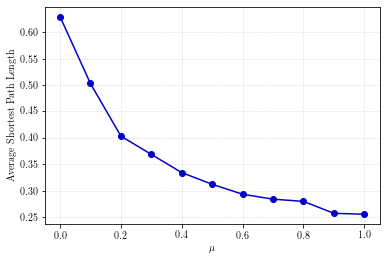

In [156]:
plt.plot(B, CC, '-o', color = '#0000CC')
plt.grid(lw = 0.5, ls = 'dotted')
plt.xlabel(r"$\mu$")
plt.ylabel("Average Shortest Path Length")
#plt.savefig('Figs/SPL_mu.pdf', bbox_inches = 'tight');

In [175]:
#W = np.load('w_list_sw_sf_25_0.1_0.1.npy')
W = syn_connectivity('random', 300, p = 81/(2*299))
G = nx.from_numpy_array(1-W, create_using=nx.DiGraph)

print("Average degree : {:.0f}".format(2*G.number_of_edges() / float(G.number_of_nodes())))
print("Average shortest path length : {:.1f}".format(nx.average_shortest_path_length(G)))
print("Clustering coefficient : {:.2f}".format(nx.average_clustering(G)))

Average degree : 81
Average shortest path length : 1.9
Clustering coefficient : 0.14


## Run algorithm

In [115]:
N_rec = 300
nb_sim = 1000
mask = syn_connectivity('scale_free', N_rec, m = 25, m0 = 25)
Output, W_list, spikemon_in1, spikemon_in2, spikemon_rec, target_seq = e_prop1(N_rec, mask.reshape((N_rec*N_rec)), nb_sim)

100%|██████████| 1000/1000 [34:56<00:00,  2.10s/it]


In [116]:
np.save("w_list_sf_25.npy", np.array(W_list))

## Results

Final average firing rate : 17.996666666666666


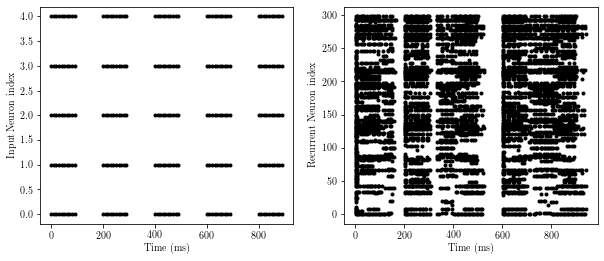

In [117]:
################################################################################
# RASTER PLOTS
################################################################################

figure(figsize=(10, 4))
subplot(121)
plot(spikemon_in1.t/ms, spikemon_in1.i,'.k') # raster plot of the input neurons (of group 1)
xlabel('Time (ms)')
ylabel('Input Neuron index');

subplot(122)
plot(spikemon_rec.t/ms, spikemon_rec.i, '.k') # raster plot of the recurrent neurons
xlabel('Time (ms)')
ylabel('Recurrent Neuron index');

print('Final average firing rate : {}' .format(spikemon_rec.num_spikes/(N_rec))) # simulation time is 1s
# Good def for firing rate ?

Best epoch : 778
MSE : 0.067
MSE of filtered output : 0.046


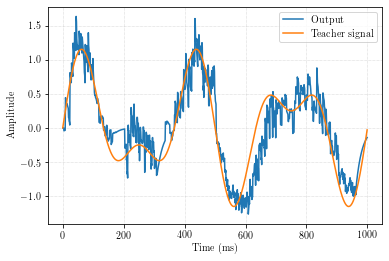

In [120]:
################################################################################
# OUTPUT PLOT
################################################################################

# Note : sometimes the output is 'reversed', so one need to replace A[k] by -A[k]

min_mse = - 1
ind = 0
v_mse = []

for k in range(nb_sim):
    mse = np.mean(np.mean(((Output[k] - target_seq))**2, axis = 1)/np.max(np.abs(target_seq), axis = 1))
    v_mse += [mse]
    if (min_mse < 0 or mse < min_mse):
        min_mse = mse
        ind = k
    
print('Best epoch : {}'. format(ind))
print('MSE : {}'.format(round(min_mse, 3)))

yh = [savgol_filter(Output[ind][k], 51, 3) for k in range(1)]
print('MSE of filtered output : {}'.format(round(np.mean(np.mean(((yh - target_seq))**2, axis = 1)/np.max(np.abs(target_seq), axis = 1)),3)))

n = 0
plot(Output[ind][n], label = 'Output')
#plot(yh[n], label = 'Filtered output')
plot(target_seq[n], label = 'Teacher signal')

grid(lw = 0.5, ls = 'dotted')
xlabel("Time (ms)")
ylabel("Amplitude")
legend();
#savefig('Figs/output_sf_25.pdf', bbox_inches = 'tight')

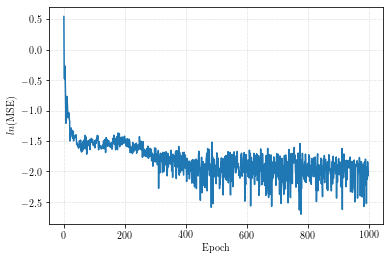

In [119]:
plot(log(v_mse))
#title('MSE VS Epochs')
grid(lw = 0.5, ls = 'dotted')
xlabel('Epoch')
ylabel('$ln$(MSE)');
#savefig('Figs/mseVSepoch_sf_25.pdf', bbox_inches = 'tight')

## Graph metrics 

In [477]:
# Plot evolution of degree, spl, cc with damp

def graph_metrics(mu_list):
    D_mean = []
    D_std = []
    SPL = []
    CC = []
    for mu in mu_list:
        mask = sw_sf(300, 25, mu, 0.1)

        # Compute graph metrics
        G = nx.from_numpy_array(1-mask, create_using=nx.DiGraph)
        k = list(dict(G.degree).values())
        D_mean.append(np.mean(k))
        D_std.append(np.std(k))
        SPL.append(nx.average_shortest_path_length(G))
        CC.append(nx.average_clustering(G))
  
    return D_mean, D_std, SPL, CC

In [478]:
mu_list = np.linspace(0,1,11)
D_mean, D_std, SPL, CC = graph_metrics(mu_list)

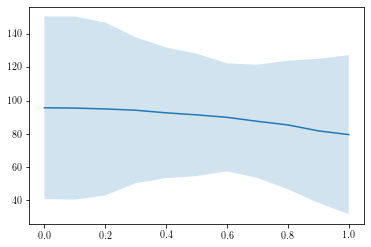

In [479]:
# degree is ~ 4*m
plt.plot(mu_list, D_mean)
plt.fill_between(mu_list, np.array(D_mean) -np.array(D_std), np.array(D_mean)+np.array(D_std), alpha = 0.2);

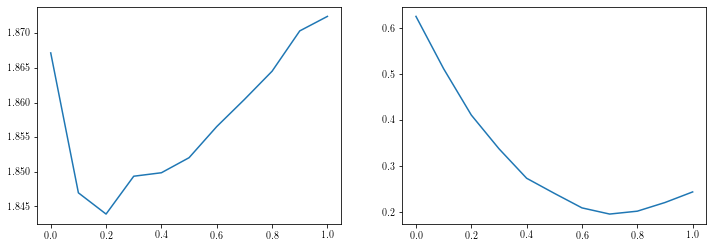

In [480]:
figure(figsize=(12, 4))
subplot(121)
plt.plot(mu_list, SPL);

subplot(122)
plt.plot(mu_list, CC);

cc : set d = 0.1. keep mu small

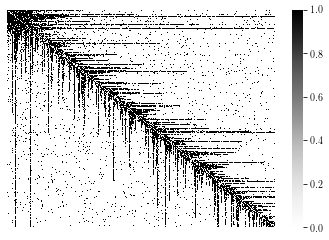

In [94]:
yyy = sw_sf(300, 25, 0.1, 0.1)
sns.heatmap(1-yyy, cmap = 'Greys', xticklabels=False, yticklabels=False);#, vmin=0, vmax=1);

95.44


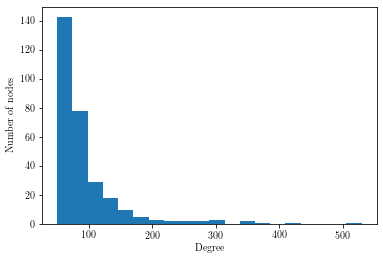

In [503]:
b = sw_sf(300, 25, 0.1, 0.1)
G = nx.from_numpy_array(1-b, create_using=nx.DiGraph)
print(np.mean(list(dict(G.degree).values())))
plt.hist(dict(G.degree).values(), bins=20)
plt.xlabel("Degree")
plt.ylabel("Number of nodes");

115.85333333333334


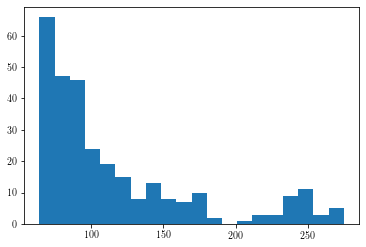

In [83]:
b = Barabasi_Albert(300, 35, 35)
G = nx.from_numpy_array(1-b, create_using=nx.DiGraph)
print(np.mean(list(dict(G.degree).values())))
plt.hist(dict(G.degree).values(), bins=20);

In [92]:
SPL = []
CC = []

M = np.arange(20,41)

for m in M:
    x = Barabasi_Albert(300, m,m)
    G = nx.from_numpy_array(1-x, create_using=nx.DiGraph)
    SPL.append(nx.average_shortest_path_length(G))
    CC.append(nx.average_clustering(G))

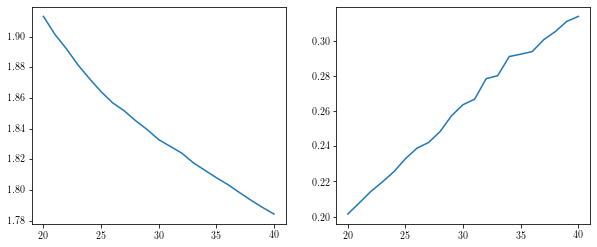

In [93]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(M, SPL);

plt.subplot(122)
plt.plot(M, CC);

In [512]:
x=Watts_Strogatz(300, 25, 0.03)
# Average degree is 4*m again (2* 2*m because of directivity)

G = nx.from_numpy_array(1-x, create_using=nx.DiGraph)
#G = nx.from_numpy_array(W2, create_using=nx.DiGraph)

print("Average degree : {}".format(2*G.number_of_edges() / float(G.number_of_nodes())))
print("Average shortest path length : {}".format(nx.average_shortest_path_length(G)))
print("Clustering coefficient : {}".format(nx.average_clustering(G)))

Average degree : 99.94666666666667
Average shortest path length : 2.200133779264214
Clustering coefficient : 0.6761509043876536


In [56]:
SPL = []
CC = []

B = np.linspace(0, 0.1, 10)

for beta in B:
    x = Watts_Strogatz(300, 20, beta)
    G = nx.from_numpy_array(1-x, create_using=nx.DiGraph)
    SPL.append(nx.average_shortest_path_length(G))
    CC.append(nx.average_clustering(G))

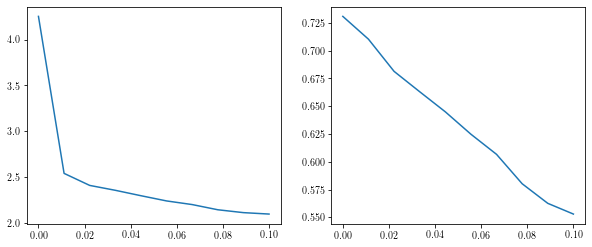

In [57]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(B, SPL);

plt.subplot(122)
plt.plot(B, CC);
# beta = 0.03 is good

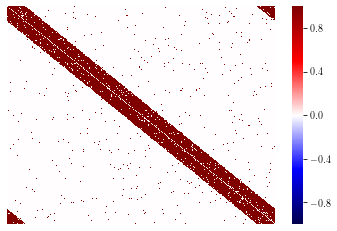

In [373]:
sns.heatmap(1-x, cmap = 'seismic', xticklabels=False, yticklabels=False, vmin=-1, vmax=1);

### Heatmap evolution

In [198]:
W = np.load('w_list_exp_20.npy')

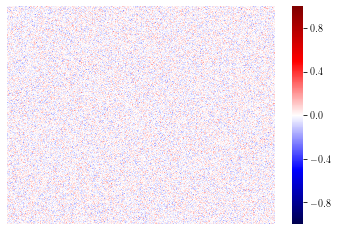

In [177]:
# Before training
sns.heatmap(W[0], cmap = 'seismic', xticklabels=False, yticklabels=False, vmin=-1, vmax=1);

In [ ]:
# After training
sns.heatmap(W[-1], cmap = 'seismic', xticklabels=False, yticklabels=False, vmin=-1, vmax=1)
savefig('Figs/weights_exp.pdf', bbox_inches = 'tight');

### Clustermaps

In [180]:
np.linalg.matrix_rank(W[-1])

300

In [ ]:
sns.clustermap(W[-1], cmap = 'seismic', row_cluster=False, yticklabels=False, vmin=-1, vmax=1);
savefig('Figs/weights_exp_cluster.pdf', bbox_inches = 'tight');

### Other implementation (fully vectorized)

In [180]:
# Do the computation at the end instead of at every time step

def compute_gradients(N_in1, N_in2, N_rec, N_out, time, feedback_w, target_seq, 
                     spikemon_in1, spikemon_in2, spikemon_rec, statemon_rec, statemon_out):
    eligibility_traces_in1 = np.zeros((N_in1, 1))
    eligibility_traces_in2 = np.zeros((N_in2, 1))
    eligibility_traces_rec = np.zeros((N_rec, 1))
    weird_eligibility_traces = np.zeros((N_rec,1))
    sum_e_traces_in1 = np.zeros((N_in1, N_rec))
    sum_e_traces_in2 = np.zeros((N_in2, N_rec))
    sum_e_traces_rec = np.zeros((N_rec, N_rec)) # sum in the right of the synaptic update equation history
    H = np.zeros((1, N_rec))

    gradient_in1 = np.zeros((N_in1, N_rec)) # gradient of input synapses weights (group 1)
    gradient_in2 = np.zeros((N_in2, N_rec)) # gradient of input synapses weights (group 2)
    gradient_rec = np.zeros((N_rec, N_rec)) # gradient of recurrent synapses weights
    gradient_out = np.zeros((N_rec, N_out)) # gradient of output synapses weights

    diff = np.zeros((1, N_out)) # sum over k used in synaptic update

    spike_vec_in1 = np.zeros(N_in1) # spikes recording. Indice i = 1 iff input neuron i spiked at current time, else i = 0
    spike_vec_in2 = np.zeros(N_in2)
    spike_vec_rec = np.zeros(N_rec) # spikes recording. Indice i = 1 iff recurrent neuron i spiked at current time
    
    for t in range(time):
        spike_vec_in1[spikemon_in1.i[spikemon_in1.t == t*ms]] = 1
        spike_vec_in2[spikemon_in2.i[spikemon_in2.t == t*ms]] = 1
        spike_vec_rec[spikemon_rec.i[spikemon_rec.t == t*ms]] = 1

        diff[0,:] = statemon_out.y[:,t] - target_seq[:,t] 
        V = np.diag(np.dot(diff, feedback_w).reshape(N_rec))

        H[0,:] = gamma * np.maximum(0, 1 - abs((statemon_rec.v[:,t] - v_th)/v_th))

        sum_e_traces_in1 = np.dot(kappa, sum_e_traces_in1) + np.dot(eligibility_traces_in1, H)
        
        gradient_in1 += np.dot(sum_e_traces_in1, V)

        sum_e_traces_in2 = np.dot(kappa, sum_e_traces_in2) + np.dot(eligibility_traces_in2, H)
        gradient_in2 += np.dot(sum_e_traces_in2, V)

        sum_e_traces_rec = np.dot(kappa, sum_e_traces_rec) + np.dot(eligibility_traces_rec, H)
        gradient_rec += np.dot(sum_e_traces_rec, V)

        weird_eligibility_traces = np.dot(kappa ** (1), weird_eligibility_traces) + spike_vec_rec.reshape((N_rec,1))
        gradient_out += np.dot(weird_eligibility_traces, diff)
        """
        if ((step + 1) % n_batch) == 0 : # weights are updated every n_batch

            # Firing rate regularization
            f_av = spikemon_rec.num_spikes/((time_step/(1000*ms)) * N_rec * n_batch) # num_spikes = nombre total de spikes
            cst = 2 * 1/((time_step/(1000*ms)) * N_rec * n_batch) * (f_av - f_target)
            gradient_rec += np.dot((1/2) * cst, np.dot(eligibility_traces_rec, H)) # the firing rate regularization is multiplied by 1/2 then added to the gradient
        """

        # Eligibility traces are computed at the end because at current time t, we need their value at time t-1
        eligibility_traces_in1 = np.dot(alpha, eligibility_traces_in1) + spike_vec_in1.reshape((N_in1,1))
        eligibility_traces_in2 = np.dot(alpha, eligibility_traces_in2) + spike_vec_in2.reshape((N_in2,1))
        eligibility_traces_rec = np.dot(alpha, eligibility_traces_rec) + spike_vec_rec.reshape((N_rec,1))

        # Reset the vector of spikes
        spike_vec_in1 = np.zeros(N_in1)
        spike_vec_in2 = np.zeros(N_in2)
        spike_vec_rec = np.zeros(N_rec)
        
    return gradient_in1, gradient_in2, gradient_rec, gradient_out 

In [41]:
time_simulation = 1000
A = np.array([[alpha**(t-tprime) if t >= tprime else 0 for tprime in range(time_simulation)] for t in range(time_simulation)])
K = np.array([[kappa**(t-tprime) if t >= tprime else 0 for tprime in range(time_simulation)] for t in range(time_simulation)])

In [46]:
A = np.array([[alpha**(t-tprime) if t >= tprime else 0 for tprime in range(time_simulation)] for t in range(time_simulation)])

A = np.vstack([np.zeros(time_simulation), A[:-1,:]])

# since we need z at time t-1, first row full of 0 and remove last row

# Should match the article. However, doesn't match previous implementation. Seems like previous implementation
# is equivalent to 2 rows of zeros. Try both !!!

In [42]:
# Should match previous implementation

A = np.array([[alpha**(t-tprime) if t >= tprime else 0 for tprime in range(time_simulation)] for t in range(time_simulation)])

A = np.vstack([np.zeros(time_simulation), np.zeros(time_simulation), A[:-2,:]])

In [495]:
# for connections recurrent --> out 

d_rec = spikemon_rec.spike_trains()

# Z_rec can be re-used for rec --> rec and rec --> out
Z_rec = np.zeros((1000, 300)) # n : simulation time ; m : nb of input neurons

for k in d_rec.keys():
    if (d_rec[k]/ms).size > 0:
        Z_rec[(d_rec[k]/ms).astype(int), k] = 1

S_out = np.dot(K, Z_rec)

# compute part with random feedback and sum over outputs --> dim (1000, 300) # can be re-used
err = statemon_out.y - target_seq

grad_out = np.dot(err, S_out)

In [496]:
grad_out.shape

(1, 300)

In [ ]:
# New formulation of learning rule (fully vectorized) --> too long because matrices too big !

N_in1 = 5
N_in2 = 5
N_rec = 300
N_out = 1
time_simulation = 1000


d_in1 = spikemon_in1.spike_trains()
d_in2 = spikemon_in2.spike_trains()
d_rec = spikemon_rec.spike_trains()

Z_in1 = np.zeros((time_simulation, N_in1)) # n : simulation time ; m : nb of input neurons
Z_in2 = np.zeros((time_simulation, N_in2))
Z_rec = np.zeros((time_simulation, N_rec))

for k in d_in1.keys():
    if (d_in1[k]/ms).size > 0:
        Z_in1[(d_in1[k]/ms).astype(int), k] = 1
        
for k in d_in2.keys():
    if (d_in2[k]/ms).size > 0:
        Z_in2[(d_in2[k]/ms).astype(int), k] = 1
        
for k in d_rec.keys():
    if (d_rec[k]/ms).size > 0:
        Z_rec[(d_rec[k]/ms).astype(int), k] = 1

        
Z_hat_in1 = np.dot(A, Z_in1) # shape --> (1000, 5)
Z_hat_in2 = np.dot(A, Z_in2)
Z_hat_rec = np.dot(A, Z_rec)

"""
# compute H --> shape : (300, 1000)
H = gamma * np.maximum(0, 1 - abs((statemon_rec.v - v_th)/v_th))

# compute E --> should have dim (1000, 5, 300). E[t,j,i] = H[j,t] * Z_hat[t,i]
E_in1 = np.multiply(H[:,:,None], Z_hat_in1[None, :,:])
E_in2 = np.multiply(H[:,:,None], Z_hat_in2[None, :,:])
E_rec = np.multiply(H[:,:,None], Z_hat_rec[None, :,:])
#E = E.transpose([1,2,0])

# compute X (S defined at the end) --> dim (1000, 300, 5)
X_in1 = np.dot(K, E_in1)
X_in2 = np.dot(K, E_in2)
X_rec = np.dot(K, E_rec)

# compute part with random feedback and sum over outputs --> dim (1000, 300)
err = statemon_out.y - target_seq
V = np.dot(err.T, feedback_w)

# combine parts
G_in1 = np.multiply(V[:,:,None], X_in1)
G_in2 = np.multiply(V[:,:,None], X_in2)
G_rec = np.multiply(V[:,:,None], X_rec)

# Final gradient
grad_in1 = np.sum(G_in1, axis = 0)
grad_in2 = np.sum(G_in2, axis = 0)
grad_rec = np.sum(G_rec, axis = 0)

"""

### End

# Justification de l'algorithme :

$ 
\ast ~~ \hat{z}_i^t = \sum \limits_{t' \leq ~ t} \alpha^{t-t'} z_i^{t'} \Longrightarrow \hat{z}_i^{t+1} = \alpha \cdot \hat{z}_i^t + z_i^{t+1}
\\ \text{De même, en notant } S_{i,j}^t = \sum \limits_{t' \leq ~ t} \kappa^{t-t'} h_j^{t'} \hat{z}_i^{t'-1}, \text{ on a :} 
\\ \ast ~~ S_{i,j}^{t+1} = \kappa \cdot S_{i,j}^t + h_j^{t+1} \cdot \hat{z}_i^t
\\ \
\\ \text{Et l'update synaptique s'écrit :}
\\ \ast ~~ \Delta \theta_{i,j}^{\text{rec},t} =  \eta \cdot \sum \limits_{k ~ \in ~ \text{outputs}} B_{k,j}^{\text{rand}}(y_k^{*,t} - y_k^t) \cdot S_{i,j}^t
\\ \
\\ \text{Avec la vectorisation :}
\\ \
\\ \ast ~~ \text{diff} = (y_k - y_k^{*})_{1 \leq k \leq N\_out}
\\ \ast ~~ V = \text{diff} * \text{feedback_w} = \left( \sum \limits_{k=1}^{N\_out} (y_k - y_k^{*})B_{k,j}^{\text{rand}} \right)_{1 \leq j \leq N\_rec}
\\ \ast ~~ S_{i,j}^{t+1} = \kappa \cdot S_{i,j}^t + h_j^{t+1} \cdot \hat{z}_i^t \Longrightarrow S^{t+1} = \kappa \cdot S^t + \hat{z}^t * h^{t+1}
\\ \ast ~~ \text{Soit } A = diag(V) = \begin{bmatrix}
    v_{1} & & \\
    & \ddots & \\
    & & v_{N\_rec}
  \end{bmatrix}.
\\ S^t A = (s_{i,j} \cdot v_j)_{1 \leq i,j \leq N\_rec} = \left (\sum \limits_{t' \leq ~ t} \kappa^{t-t'} h_j^{t'} \hat{z}_i^{t'-1} \cdot \sum \limits_{k=1}^{N\_out} (y_k - y_k^{*})B_{k,j}^{\text{rand}} \right)_{1 \leq i,j \leq N\_rec}.
\\ \ \text{On retrouve bien le gradient.}
$

